In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import Xlnk, Overlay

In [2]:
channel_extract_design = Overlay("extract_channel.bit")

In [3]:
dma = channel_extract_design.axi_dma_0
extractor = channel_extract_design.channel_extract_accel_0

In [4]:
image_path = "images/aur.jpg"
original_image = Image.open(image_path)

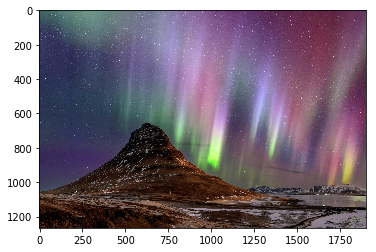

In [5]:
canvas = plt.gcf()

old_width, old_height = original_image.size
channel = 2
# red=0 green=1 blue=2
_ = plt.imshow(original_image)

In [6]:
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(old_height, old_width, 3), 
                           dtype=np.uint8, cacheable=1)
out_buffer = xlnk.cma_array(shape=(old_height, old_width, 3), dtype=np.uint8, cacheable=1)

In [7]:
in_buffer[:] = np.array(original_image)

In [8]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    extractor.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [9]:
extractor.write(0x10, old_height)
extractor.write(0x18, old_width)
extractor.write(0x20, channel)
extractor.write(0x28, channel)

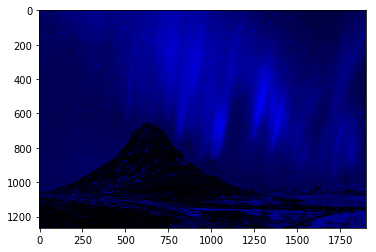

In [10]:
run_kernel()
rgbArray = np.zeros((old_height,old_width,3), 'uint8')
rgbArray[..., channel] = out_buffer[...,0]
rgb_image = Image.fromarray(rgbArray)
_ = plt.imshow(rgb_image)

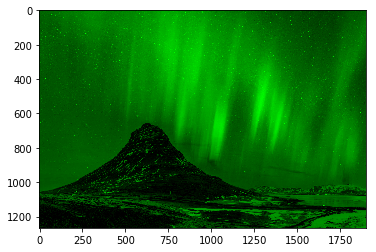

In [11]:
channel = 1
extractor.write(0x10, old_height)
extractor.write(0x18, old_width)
extractor.write(0x20, channel)
extractor.write(0x28, channel)
run_kernel()
rgbArray = np.zeros((old_height,old_width,3), 'uint8')
rgbArray[..., channel] = out_buffer[...,0]
rgb_image = Image.fromarray(rgbArray)
_ = plt.imshow(rgb_image)

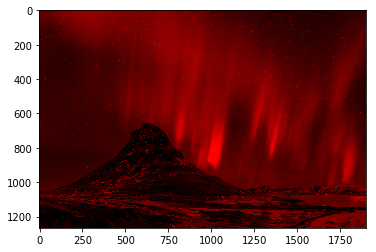

In [12]:
channel = 0
extractor.write(0x10, old_height)
extractor.write(0x18, old_width)
extractor.write(0x20, channel)
extractor.write(0x28, channel)
run_kernel()
rgbArray = np.zeros((old_height,old_width,3), 'uint8')
rgbArray[..., channel] = out_buffer[...,0]
rgb_image = Image.fromarray(rgbArray)
_ = plt.imshow(rgb_image)

In [13]:
%%timeit
run_kernel()
rgbArray[..., channel] = out_buffer[...,0]
rgb_image = Image.fromarray(rgbArray)

10 loops, best of 3: 187 ms per loop


In [14]:
%%timeit
run_kernel()

10 loops, best of 3: 80.8 ms per loop


In [15]:
xlnk.xlnk_reset()